# Проект: классификация

Александр Журавлев DST-120
***

# Итерация №2. EDA. Feature Engineering.
На прошлой итерации мы определили стратегию работы с выбросами - удаление.    
На данной итерации мы уделим внимание разведывательному анализу и созданию новых признаков.

**Примечание:** при перезапуске ноутбука значения некоторых метрик у некоторых моделей могут менятся +/- на 0.01   
Вероятно, это происходит по причине того, что алгоритмы sklearn по очистке данных носят стохастический характер.
***

# Задача
→ Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

Предоставленны данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Вы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача** для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

### Данные о клиентах банка:

- **age** (возраст);
- **job** (сфера занятости);
- **marital** (семейное положение);
- **education** (уровень образования);
- **default** (имеется ли просроченный кредит);
- **housing** (имеется ли кредит на жильё);
- **loan** (имеется ли кредит на личные нужды);
- **balance** (баланс).

### Данные, связанные с последним контактом:

- **contact** (тип контакта с клиентом);
- **month** (месяц, в котором был последний контакт);
- **day** (день, в который был последний контакт);
- **duration** (продолжительность контакта в секундах).

### Прочие признаки:

- **campaign** (количество контактов с этим клиентом в течение текущей кампании);
- **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- **previous** (количество контактов до текущей кампании)
- **poutcome** (результат прошлой маркетинговой кампании).

### Целевой признак:

- **deposit**.

***

## 0. Подготовительный этап

### Импортируем необходимые библиотеки

In [1]:

# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.covariance import EllipticEnvelope # выявляем выбросы

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

# не отображаем предупреждения
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# импортируем функции из my_functions.py
# для визуализации признаков
from my_functions import visual_cat_feature, visual_num_feature, heatmap_pair_features
# для поиска выбросов
from my_functions import outliers_iqr_mod
# для комбинации пар признаков
from my_functions import combinantorial
# для определения мультиколлинеарности
from my_functions import get_top_abs_correlations
# для OneHotEncoding тренировочной и тестовой выборок
from my_functions import encode_cat_features 
    

### Определим константы и загрузим данные

In [2]:
# для воспроизводимости результатов
random_state = 42 

In [3]:
# загрузим данные
df = pd.read_csv('data/bank_fin.csv', sep = ';')

### Преобразуем признак **balance** в числовой

In [4]:
# заменим пропуски, запятые и знак доллара в значениях признака balance
df.balance = df.balance.apply(
    lambda x: str(x).translate(str.maketrans({
        ' ': '', # убираем пробелы
        '$': '', # убираем знак $
        ',': '.' # заменяем запятую на точку
    }))
)

# преобразуем тип признака balance из object в float
df.balance = df.balance.astype(float)

***

## 1. Предварительный анализ данных

### Общий анализ

In [5]:
# выведем первые 5 строк таблицы
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no   2343.0     yes   no  unknown   
1   56      admin.  married  secondary      no     45.0      no   no  unknown   
2   41  technician  married  secondary      no   1270.0     yes   no  unknown   
3   55    services  married  secondary      no   2476.0     yes   no  unknown   
4   54      admin.  married   tertiary      no    184.0      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [6]:
# подробная информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [7]:
# ищем пропуски
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [8]:
# ищем дубликаты
df.duplicated().sum()

0

In [9]:
# анализ числовых признаков
df.describe().T

count         mean          std     min    25%    50%      75%  \
age       11162.0    41.231948    11.913369    18.0   32.0   39.0    49.00   
balance   11137.0  1529.129029  3228.114892 -6847.0  123.0  550.0  1708.00   
day       11162.0    15.658036     8.420740     1.0    8.0   15.0    22.00   
duration  11162.0   371.993818   347.128386     2.0  138.0  255.0   496.00   
campaign  11162.0     2.508421     2.722077     1.0    1.0    2.0     3.00   
pdays     11162.0    51.330407   108.758282    -1.0   -1.0   -1.0    20.75   
previous  11162.0     0.832557     2.292007     0.0    0.0    0.0     1.00   

              max  
age          95.0  
balance   81204.0  
day          31.0  
duration   3881.0  
campaign     63.0  
pdays       854.0  
previous     58.0

In [10]:
# анализ оставшихся признаков
df.describe(include='object').T

count unique         top   freq
job        11162     12  management   2566
marital    11162      3     married   6351
education  11162      4   secondary   5476
default    11162      2          no  10994
housing    11162      2          no   5881
loan       11162      2          no   9702
contact    11162      3    cellular   8042
month      11162     12         may   2824
poutcome   11162      4     unknown   8326
deposit    11162      2          no   5873

In [11]:
# количество уникальных значений всех признаков
df.nunique()

age            76
job            12
marital         3
education       4
default         2
balance      3802
housing         2
loan            2
contact         3
day            31
month          12
duration     1428
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64

**Выводы:**
- Датасет содержит 17 признаков (16 факторов и таргет). Факторы представлены числовыми и категориальными признаками.
- Числовые признаки: **age**, **balance**, **duration**, **campaign**, **pdays**, **previous**.
- Категориальные номинальные признаки - все оставшиеся, включая целевую переменную. 
- Обнаружено 25 пропусков в признаке **balance** (непрерывный числовой признак)

### Корреляции изначальных признаков

В датасете присутствуют непрерывные и категориальные числовые признаки, таргет - категориальный признак. Расчитаем корреляции по методам Пирсона, Кендалла, Спирмена.

In [12]:
# создадим новый признак target - бинарный цифровой вариант deposit
df['target'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

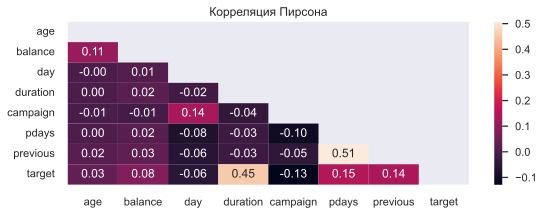

In [13]:
# визуализируем корреляцию Пирсона числовых признаков
sns.set(rc={'figure.figsize':(9,3)})
sns.heatmap(df.corr(), annot=True, fmt='.2f', mask = np.triu(df.corr())).set(title = "Корреляция Пирсона");

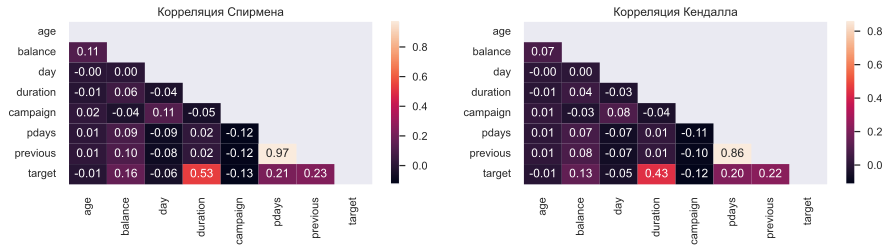

In [14]:
# визуализируем корреляции Спирмена и Кендалла
fig, ax =plt.subplots(1, 2, figsize=(15, 3))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.2f',mask = np.triu(df.corr()), ax=ax[0]).set(title = "Корреляция Спирмена");
sns.heatmap(df.corr(method='kendall'), annot=True, fmt='.2f',mask = np.triu(df.corr()), ax=ax[1]).set(title = "Корреляция Кендалла");
fig.show();

**Выводы:**
- Отмечается корреляция (от средней до очень сильной) признаков **pdays** и **previous**
- Наиболее высокая степень корреляции с таргетом у следующих признаков (по нисходящей): **duration**, **previous**, **pdays**.

In [15]:
# удалим уже ненужный признак target
df.drop('target', axis=1, inplace=True)

## 2. Последовательно анализируем каждый признак

### 2.1. Признак **age**

Возраст клиентов.   

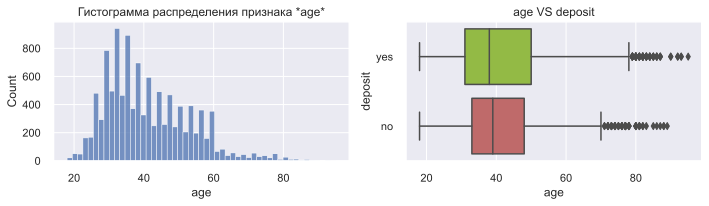

In [16]:
# визуализируем признак age
visual_num_feature(df, 'age')

Возраст от 18 до 95 лет - явных аномалий нет. Медиана в обеих коробках смещена влево, границы распределений справа шире, чем слева. Межквартильный размах верхней коробки (target='yes') несколько больше, чем у нижней и ее правый ус шире.

Выделим из данного признака возрастные группы. Фактически, мы выделим категориальный признак из числового. Назовем новый признак **age_group**.

In [17]:
# создадим новый признак age_group;

# для создания категорий используем метод cut()
df['age_group'] = pd.cut(
    df.age, [0,30,40,50,60,9999], 
    labels = ['<30','30-40','40-50','50-60','60+']
)

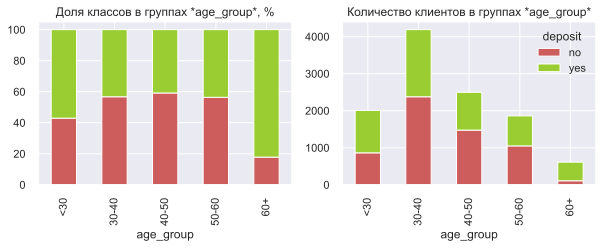

In [18]:
# визуализируем признак age_group
visual_cat_feature(df, 'age_group')

Наибольшая доля клиентов (более 80%), открывших депозит, находится в группе "60+", однако доля всей этой группы среди остальных клиентов наименьшая. На втором месте по доле открытых депозитов - группа < 30. В остальных возрастных группах доля открывших депозит менее 50%.

Отметим это, создав новый признак **age_group_class_1**.

In [19]:
# создадим новый признак age_group_class_1
class_1 = ['60+', '<30'] # здесь больше доля 1 класса
df['age_group_class_1'] = df['age_group'].apply(
    lambda x: 1 if x in class_1 else 0
)

### 2.2. Признак **job**

Место работы клиента.

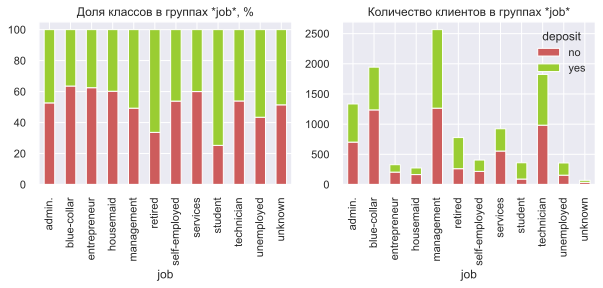

In [20]:
# визуализируем признак job
visual_cat_feature(df, 'job')

Место работы клиента:
- **management** - управление
- **blue-collar** - "синие воротнички", понятие (термин), обозначающее принадлежность работника к рабочему классу, представители которого, как правило, заняты физическим трудом с почасовой оплатой
- **technician** - техник, мастер, механик, ремонтник
- **admin.** - администратор
- **services** - сфера услуг
- **retired** - отставник, пенсионер
- **self-employed** - самозанятый
- **student** - студент, учащийся
- **unemployed** - безработный
- **entrepreneur** - предприниматель
- **housemaid** - домработник/ца или должность в сфере обслуживание гостиниц и подобных заведений на уровне официанта, горничной, уборщицы.
- **unknown** - неявный пропуск

Самая высокая доля открытых депозитов в группе *student* и *retired*, что явно перекликается с возрастными группами выше - клиенты 60+ и младше 30 чаще открывают депозит. Наименьшая доля открытых депозитов в группах *blue-collar*, *entrepreneur*. Интересно отметить, что в группе *unemployed* депозиты чаще открывают.    
Неявных пропусков мало, доли классов в них сбалансированы.

Создадим новый сигнальный признак.

In [21]:
# создадим признак job_class_1
class_1 = ['student', 'retired', 'unemployed'] # здесь больше доля класса 1
df['job_class_1'] = df['job'].apply(
    lambda x: 1 if x in class_1 else 0
)

### 2.3. Признак **marital**

Семейное положение клиента. 

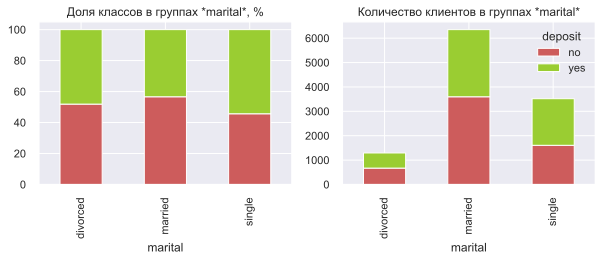

In [22]:
# визуализируем признак marital
visual_cat_feature(df, 'marital')

Неженатые/незамужние клиенты/ки чаще открывают депозит, а состоящие в браке либо разведенные клиенты - реже. Большинство клиентов состоят в браке.

### 2.4. Признак **education**

Образование клиента.

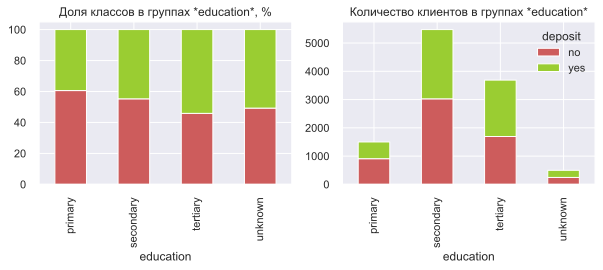

In [23]:
# визуализируем признак education
visual_cat_feature(df, 'education')

Образование клиента:
- **primary** - начальное
- **secondary** - среднее
- **tertiary** - высшее
- **unknown** - неявный пропуск

Чаще всех депозиты открывают клиенты с высшим образованием, реже - с начальным. Большинство клиентов имеют среднее образование.   
Неявных пропусков мало, доли классов в них сбалансированы.

### 2.5. Признак **default**

Наличие просроченного кредита у клиента. 

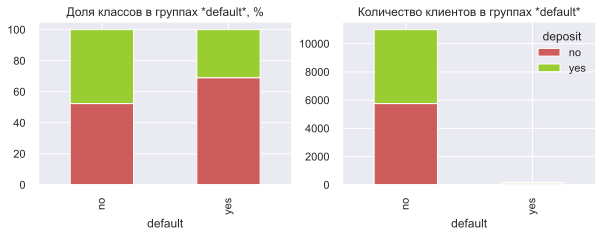

In [24]:
# визуализируем признак default
visual_cat_feature(df, 'default')

По количеству значений в группах признак явно несбалансирован. Если есть просроченный кредит, то такие клиенты реже открывают депозит.

### 2.6. Признак **balance**

Баланс на счетах клиента.   
Помним, что здесь 25 пропущенных значений.

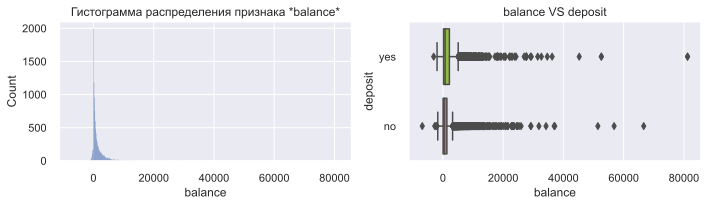

In [25]:
# визуализируем признак balance
visual_num_feature(df, 'balance')

Признак явно содержит выбросы, пометим их, использую метод Тьюки (число IQR в обе стороны 1.5).

In [26]:
# создадим признак balance_outliers с метками выбросов
df['balance_outliers'] = 0
# получим выбросы
outliers = outliers_iqr_mod(df, 'balance')
# пометим выбросы значением 1
df.loc[outliers.index, 'balance_outliers'] = 1 

lower bound = -2254
upper bound = 4086
total outliers in *balance*: 1053


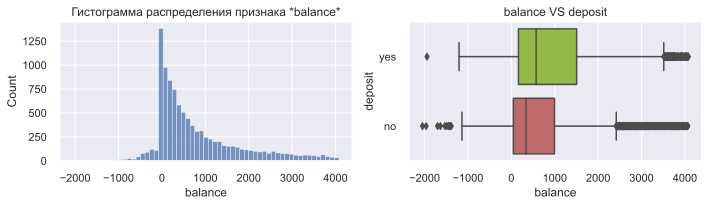

In [27]:
# визуализируем признак balance
visual_num_feature(
    df[df['balance_outliers'] == 0], # данные без выбросов
    'balance'
)

Уже лучше. Распределение признака ближе к логнормальному. У клиентов, которые открыли депозит, в целом баланс выше. Медиана в обеих коробках смещена влево, верхняя коробка (target = 'yes') шире нижней и смещена вправо, ее правый ус шире, чем у нижней коробки. Важный признак!

Попробуем разбить этот непрерывный числовой признак на группы.

In [28]:
# создадим новый признак balance_group;

# для создания категорий используем метод cut()
df['balance_group'] = pd.cut(
    df.balance, [-99999, 0, 1000, 99999], 
    labels = ['<0','0-1000', '>1000']
)

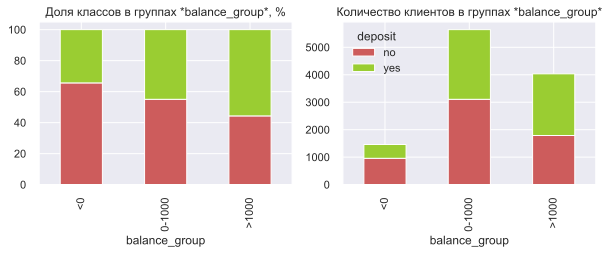

In [29]:
# визуализируем полученный признак
visual_cat_feature(df, 'balance_group')

Ну, при балансе >1000 клиенты чаще открывают депозит. Количество таких клиентов чуть меньше 4000. Клиенты с отрицательным балансом реже всех открывают депозит и таковых клиентов меньшинство.

### 2.7. Признак **housing**

Имеется ли кредит на жилье.

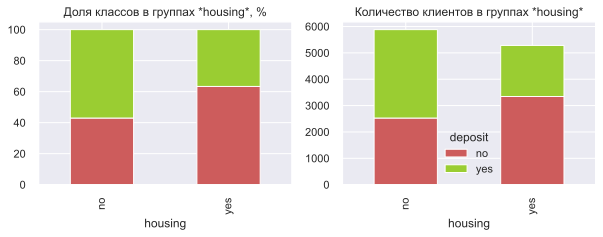

In [30]:
# визуализируем признак housing
visual_cat_feature(df, 'housing')

Клиентов, которые имеют кредит на жилье, меньше и открывают депозит они реже.

### 2.8. Признак **loan**

Имеется ли кредит на личные нужды (вероятно, имеется в виду потребительский кредит).

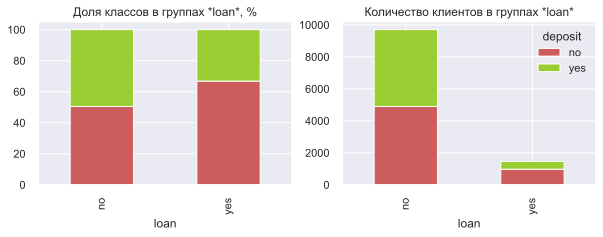

In [31]:
# визуализируем признак loan
visual_cat_feature(df, 'loan')

Клиентов, имеющих кредит на личные нужды, сильно меньше и депозит они открывают реже. Интересно, что доли классов среди клиентов без данного кредита практически равны.

### 2.9. Признак **contact**

Тип контакта клиента при предыдущей компании.

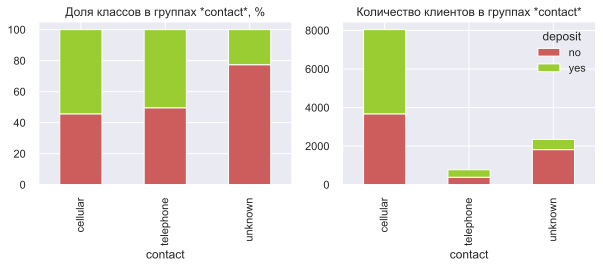

In [32]:
# визуализируем признак contact
visual_cat_feature(df, 'contact')

Интересная ситуация. В группах *cellular* и *telephone* доли классов различаются не сильно, при этом между ними сильный дисбаланс по количеству. А вот в группе *unknown* - доля открывших депозит сильно меньше. Сложный вопрос, что делать с этим признаком - много неявных пропусков. 

### 2.10. Признак **day**

День последнего контакта с клиентом.

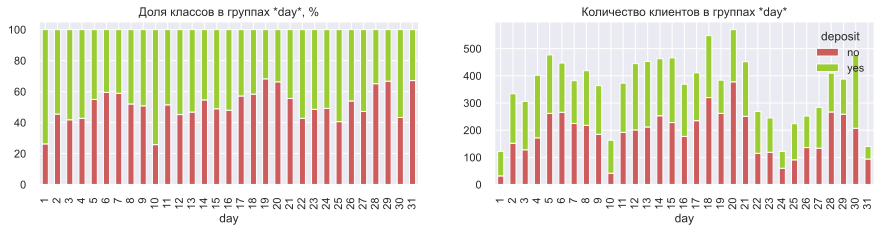

In [33]:
# визуализируем признак day как категориальный
visual_cat_feature(df, 'day', h_size=15)

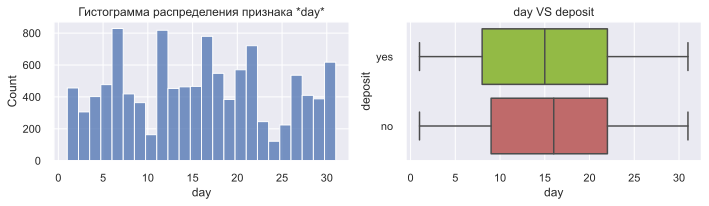

In [34]:
# визуализируем признак day как числовой
visual_num_feature(df, 'day')

Имеются выраженные дисбалансы классов:
- 1,10 дни - большее класса 1
- 19,20,28,29,31 дни - больше класса 0

Создадим новый признак:

In [35]:
# создадим новый признак day_class_1
df['day_class_1'] = df['day'].apply(
    lambda x: 1 if ((x == 1) or (x == 10)) else 0
)

### 2.11. Признак **month**

Месяц последнего контакта с клиентом.

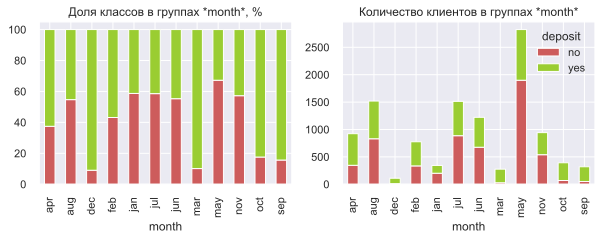

In [36]:
# визуализируем признак month
visual_cat_feature(df, 'month')

Преобразуем признак схожим образом, как и предыдущий. Создадим новый признак **year_season** выделив времена года.

In [37]:
# создадим новый признак month_class_1
month_class_1 = ['dec', 'mar', 'oct', 'sep'] # здесь чаще класс 1
df['month_class_1'] = df['month'].apply(
    lambda x: 1 if x in month_class_1 else 0
)

# создадим признак year_season
seasons = {
    'jan': 'winter',
    'feb': 'winter',
    'mar': 'spring',
    'apr': 'spring',
    'may': 'spring',
    'jun': 'summer',
    'jul': 'summer',
    'aug': 'summer',
    'sep': 'autumn',
    'oct': 'autumn',
    'nov': 'autumn',
    'dec': 'winter'
}
df['year_season'] = df['month'].apply(
    lambda x: seasons[x]
)

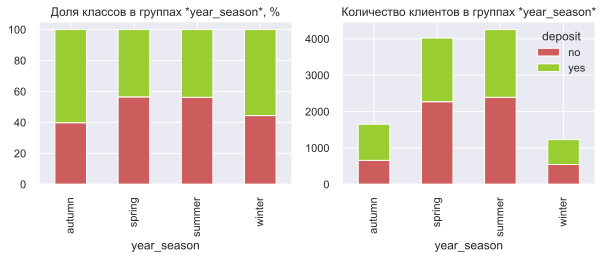

In [38]:
# визуализируем полученный признак year_season
visual_cat_feature(df, 'year_season')

Чаще в прошлый раз контактировали с клиентом весной и летом, а вот чаще открывают депозиты те, с которыми контактировали осенью и зимой.

### 2.12. Признак **duration**

Продолжительность последнего контакта в секундах с клиентом.

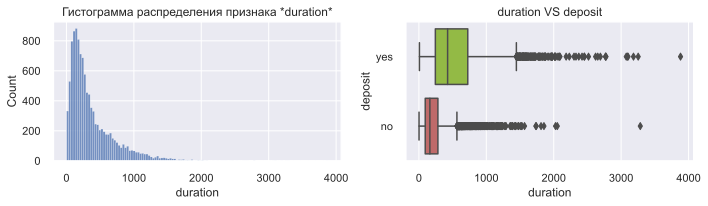

In [39]:
# визуализируем признак duration
visual_num_feature(df, 'duration')

Признак явно содержит выбросы, пометим их, использую метод Тьюки (число IQR в обе стороны 1.5).

In [40]:
# создадим признак duration_outliers с метками выбросов
df['duration_outliers'] = 0
# получим выбросы
outliers = outliers_iqr_mod(df, 'duration')
# отметим выбросы значением 1
df.loc[outliers.index, 'duration_outliers'] = 1 

lower bound = -399
upper bound = 1033
total outliers in *duration*: 636


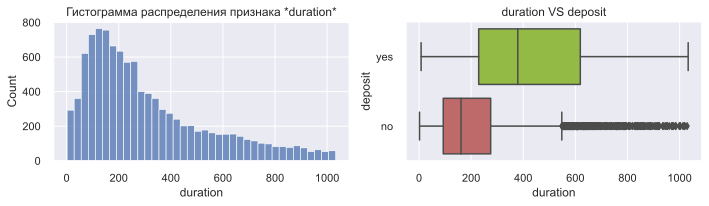

In [41]:
# визуализируем признак duration
visual_num_feature(
    df[df['duration_outliers'] == 0], # данные без выбросов
    'duration'
)

Важный признак! Коробки довольно сильно смещены по отношению друг к другу. Это, кстати говоря, подтверждается корреляцией изначальных числовых признаков с таргетом (см. выше).

In [42]:
# создадим новый признак duration_group
df['duration_group'] = pd.cut(
    df.duration, [0, 200, 400, 600, 800, 9999], 
    labels = ['<200','200-400','400-600', '600-800', '>800']
)

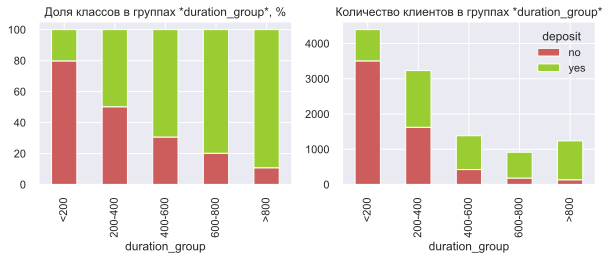

In [43]:
# визуализируем полученный признак duration_group
visual_cat_feature(df, 'duration_group')

В целом, вывод простой - чем длительнее контакт с клиентом, тем выше вероятность открытия депозита.

### 2.13. Признак **campaign**

Количество контактов с клиентом.

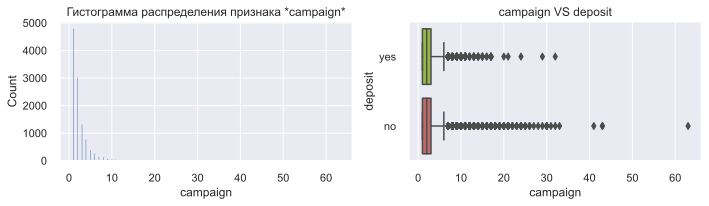

In [44]:
# визуализируем признак campaign как числовой
visual_num_feature(df, 'campaign')

In [45]:
# создадим признак campaign_outliers с метками выбросов
df['campaign_outliers'] = 0
# получим выбросы
outliers = outliers_iqr_mod(df, 'campaign')
# отметим выбросы значением 1
df.loc[outliers.index, 'campaign_outliers'] = 1

lower bound = -2
upper bound = 6
total outliers in *campaign*: 601


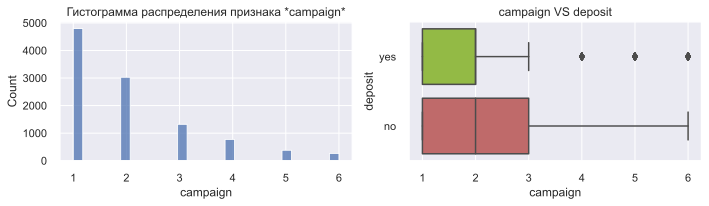

In [46]:
# визуализируем признак campaign
visual_num_feature(
    df[df['campaign_outliers'] == 0], # данные без выбросов
    'campaign'
)

Ящики отличаются по ширине: открывшие депозит имели чаще 1-2 контакта (медиана равна 1 или 2), не открывшие 1-3 контакта (медиана 2).

In [47]:
# посчитаем вручную медиану зеленого ящика
df[(df['campaign_outliers'] == 0) & (df['deposit'] == 'yes')]['campaign'].median()

2.0

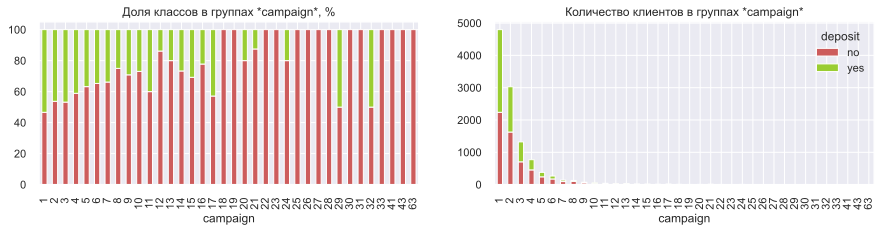

In [48]:
# визуализируем признак campaign как категориальный
visual_cat_feature(df, 'campaign', h_size=15)

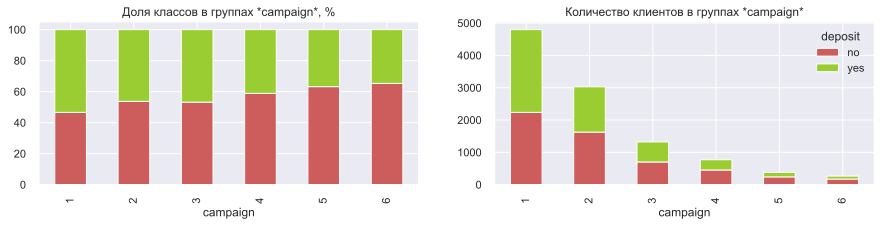

In [49]:
# визуализируем признак campaign как категориальный без выбросов
visual_cat_feature(
    df[df['campaign_outliers'] == 0], # данные без выбросов
    'campaign', 
    h_size=15
)

Ну, вобщем понятно - чем больше контактов, тем меньше таких наблюдений и реже клиент открывает депозит.

In [50]:
# создадим новый признак campaign_group
df['campaign_group'] = df['campaign'].apply(
    lambda x: x if x<=6 else 7
)

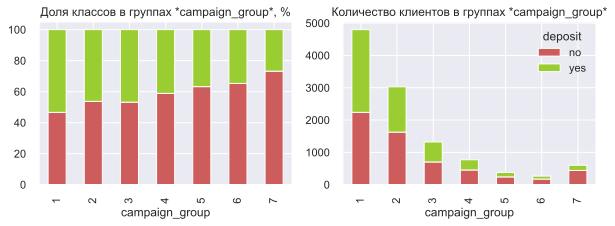

In [51]:
# визуализируем новый признак
visual_cat_feature(df, 'campaign_group')

Интересный момент. Как и предыдущий признак **duration_group**, новый признак **campaign_group** имеет 2 особенности: каждая последующая группа меньше предыдущей и доля классов линейно меняется (увеличивается доля класса 1 в первом случае и доля класса 0 во втором). Другими словами, этим признакам можно, как вариант, выполнить порядковое кодирование.

In [52]:
# кодируем в сторону увеличения доли класса 1 в группах
labels = {
    '<200': 1,
    '200-400': 2,
    '400-600': 3, 
    '600-800': 4, 
    '>800': 5
}
df['duration_group'] = df['duration_group'].apply(
    lambda x: labels[x]
)
df = df.astype({'duration_group':'int64'})
labels = {
    1: 7,
    2: 6,
    3: 5, 
    4: 4, 
    5: 3,
    6: 2,
    7: 1
}
df['campaign_group'] = df['campaign_group'].apply(
    lambda x: labels[x]
)

### 2.14. Признак **pdays**

Количество дней, прошедших с момента контакта с клиентом во время предыдущей компании до момента контакта в рамках текущей компании.

In [53]:
# проверим на аномалии
mask = df['pdays'] < 0 # значения меньше 0
df[mask]['pdays'].value_counts()

-1    8324
Name: pdays, dtype: int64

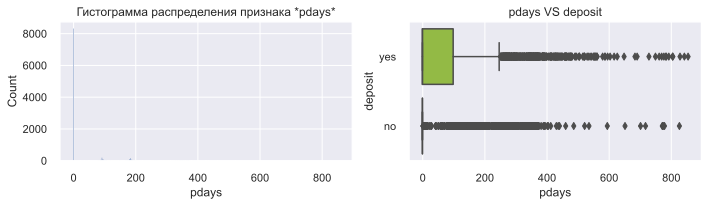

In [54]:
# визуализируем признак pdays
visual_num_feature(df, 'pdays')

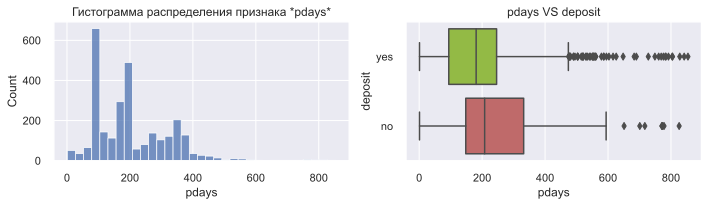

In [55]:
# еще раз визуализируем признак pdays
visual_num_feature(
    df[df['pdays'] >=0], # только значения >=0
    'pdays'
)

Очень непонятный признак. Значение -1 явная аномалия, но этих значений более 8тыс. Возможно, речь идет о том, что предыдущая и текущая компания проводится в один день, тогда в этом случае мы получаем значение признака -1. При этом есть явные смещения коробок друг относительно друга в общем случае и в случае, если учитывать только значения признака >=0. То есть признак очень важен для задачи классификации. При попытке выделить выбросы (метод Тьюки) - ценность признака явно снижается.

Попробуем другой вариант обработки данного признака: разделим его на группы.

In [56]:
# создадим новый признак pdays_group
df['pdays_group'] = pd.cut(
    df.pdays, [-9999, 0, 200, 400, 9999], 
    labels = ['<0','0-200','200-400', '>400']
)

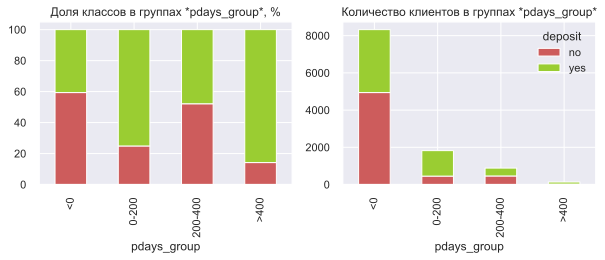

In [57]:
# визуализируем полученный признак
visual_cat_feature(df, 'pdays_group')

Количество значений в каждой группе последовательно снижается, но при этом есть дисбаланс в пользу класса 1 в двух группах из четырех.    
Создадим еще один признак.

In [58]:
# создадим новый признак pdays_group_class_1
class_1 = ['0-200', '>400'] # здесь чаще класс 1
df['pdays_group_class_1'] = df['pdays_group'].apply(
    lambda x: 1 if x in class_1 else 0
)

### 2.15. Признак **previous**

Количество контактов с клиентом до текущей компании.

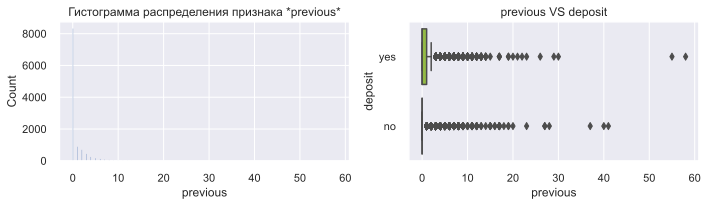

In [59]:
# визуализируем признак previous как числовой
visual_num_feature(df, 'previous')

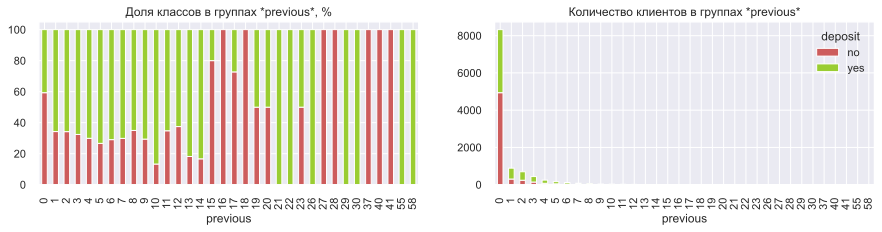

In [60]:
# визуализируем признак previous как категориальный
visual_cat_feature(df, 'previous', h_size=15)

Тут все понятно. 0 - это отсутствие контактов (большинство клиентов), т.е. можно разделить данные на 0 - отсутствие контактов и 1 - контакты имелись.

In [61]:
# создаем новый бинарный признак заменив старый признак
df['previous'] = df['previous'].apply(
    lambda x: 0 if x == 0 else 1
)

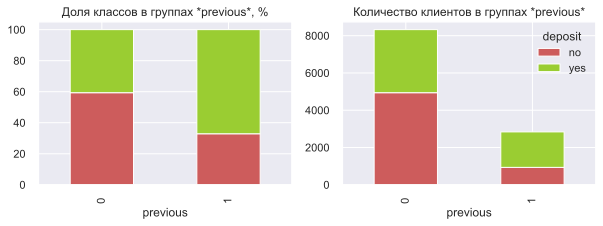

In [62]:
# визуализируем полученный признак
visual_cat_feature(df, 'previous')

Если контактов до текущей компании с клиентом не было, то чаще всего (почти в 60% случаев) клиент депозит не открывает. А если контакты были - наоборот. Мы получили важный признак.

### 2.16. Признак **poutcome**

Результат прошлой маркетинговой компании.

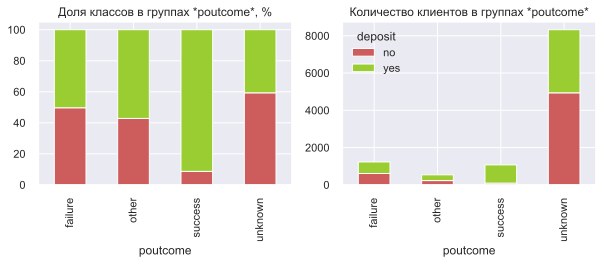

In [63]:
# визуализируем признак poutcome
visual_cat_feature(df, 'poutcome')

Мда... Неявный пропуск является и модальным значением данного признака.     
Мы видим интересную вещь - значение *success* в подавляющем случае означает открытие депозита в текущей компании. Можно, конечно, вытащить это значение признака **poutcome** в отдельный бинарный признак, что окажет большое влияние на итоговый результат модели. Проблема, однако, в том, что при наличии такого большого количества пропусков в данном признаке мы не можем достоверно знать реальное соотношение значений этого признака. Другими словами, на представленных данных модель обучится хорошо, но что произойдет при добавлении новых данных?      
Еще один интересный момент. Наибольшее количество неявных пропусков мы видим в признаках **contact** и **poutcome**. Соотношение классов в этих пропусках явно в пользу отказа от открытия депозита.

### 2.17. Признак **deposit** (целевая переменная)

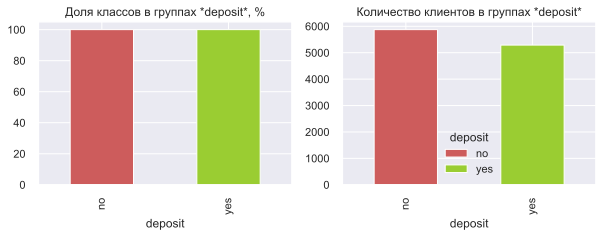

In [64]:
# визуализируем признак
visual_cat_feature(df, 'deposit')

Классы несбалансированы. Чаще клиенты не открывают депозит. При удалении пропусков - ситуация становится противоположной (см. прошлую итерацию), причина - в неявных пропусках преобладает класс 'no' целевого признака. Возможно, именно поэтому мы получали на прошлой итерации рост метрик класса 'no' при замене пропусков модой или предиктами.

## 3. Создание новых признаков

Часть новых признаков мы уже создали при анализе данных выше. Попробуем создать еще.

### 3.1. Создадим новые непрерывные числовые признаки

In [65]:
#Создаем новый признак - отношение баланса и возраста
df['AgeBalanceRatio'] = df['balance'] / df['age']
#Создаем новый признак - отношение продолжительности разговора к кол-ву контактов 
df['DurationCampaignRatio'] = df['duration'] / df['campaign']
#Создаем новый признак - отношение pdays и camapaign 
df['PdaysCampaignRatio'] = df['pdays'] / df['campaign']

### 3.2. Анализ взаимоотношений пар категориальных признаков и создание новых признаков

У нас есть функция **heatmap_pair_features**, которая позволяет визуализировать взаимоотношение пар категориальных признаков в разрезе класса таргета. Это позволяет находить дополнительную интересную информацию.    
Например, попробуем глянуть на взаимоотношение пар признаков **marital** и **education**.

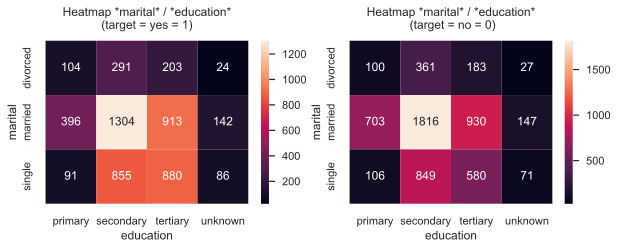

In [66]:
# визуализируем взаимосвязь признаков marital и education
heatmap_pair_features(df, 'marital', 'education', 1000, 0.1, 0.5)

Параметры функции мы прокоментируем ниже.   
На данных тепловых картах мы видим, например, что самая большая группа клиентов из представленных - состоящие в браке и имеющие среднее образование, причем чаще эта группа отказывается от депозита в рамках текущей компании. А вот группа клиентов не состоящих в браке и имеющая высшее образование чаще депозит открывает (как и группа разведенных с высшим образованием).    
Можно найти много интересной информации для анализа клиентов, однако в контексте решения задачи проекта нам необходимо найти такие сочетания признаков, которые помогут нам создать новые признаки улучшающие метрику моделей. Займемся этим ниже.

In [67]:
# отбираем признаки для определения взаимосвязи
features = [
    'age_group', 'job', 'marital', 'education', 
    'balance_group', 'housing', 'loan', 'contact', 'day',
    'year_season', 'pdays_group', 
    'previous', 'duration_group', 'campaign_group'
]

# создаем необходимые уникальные комбинации отобраных признаков
# в виде списка из кортежей
features_pair = combinantorial(features)
print(f'Всего создано {len(features_pair)} пар признаков')


Всего создано 91 пар признаков


there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions


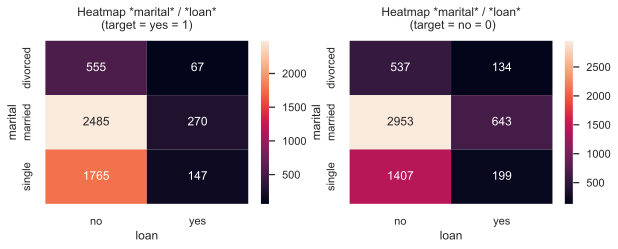

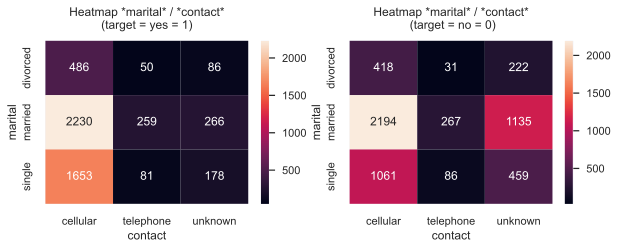

In [68]:
# визуализируем взаимосвязь категориальных признаков
for pair in features_pair[0:30]: # первые 30 пар
    heatmap_pair_features(
        df, # датасет
        pair[0], # первый признак
        pair[1], # второй признак
        2000, # минимальный уровень кол-ва значений в классе 1 для вывода 
        0.1, 0.3, # диапазон долей несбалансированности классов для вывода
        h_size=10 # ширина графика
    )

Создадим новые признаки согласно следующим критериям:
- в сочетании признаков клиентов класса 1 больше (чем выше дисбаланс, тем лучше)
- количество клиентов в данном сочетании признаков достаточно большое

In [69]:
# создадим признак marital(single)_loan(no)
df['marital(single)_loan(no)'] = df.apply(
    lambda row: 1 if ((row['marital'] == 'single') & (row['loan'] == 'no')) else 0,
    axis=1
)
# создадим признак marital(married)_contact(cellular)
df['marital(married)_contact(cellular)'] = df.apply(
    lambda row: 1 if ((row['marital'] == 'married') & (row['contact'] == 'cellular')) else 0,
    axis=1
)

there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions


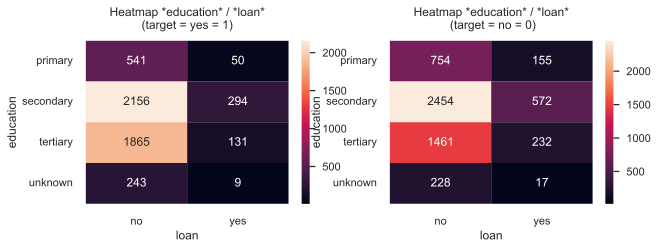

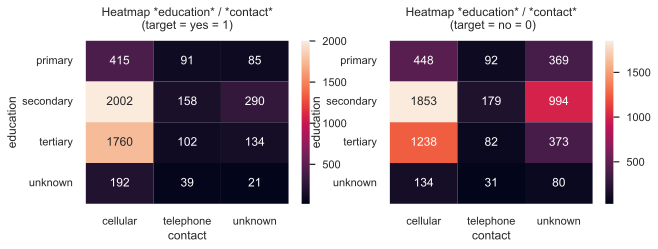

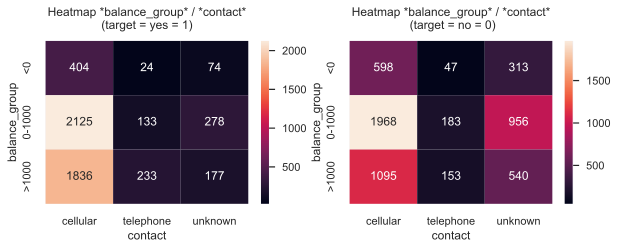

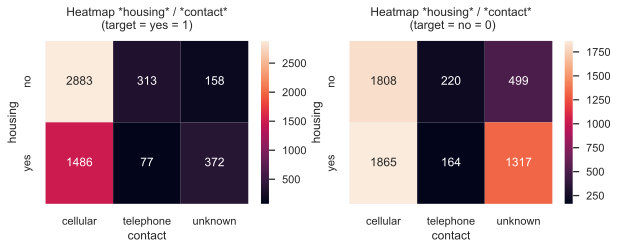

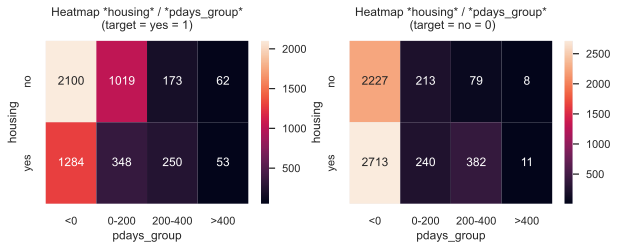

In [70]:
# визуализируем взаимосвязь категориальных признаков
for pair in features_pair[30:60]: # вторые 30 пар
    heatmap_pair_features(
        df, # датасет
        pair[0], # первый признак
        pair[1], # второй признак
        2000, # минимальный уровень кол-ва значений в классе 1 для вывода 
        0.1, 0.3, # диапазон долей несбалансированности классов для вывода
        h_size=10 # ширина графика
    )

In [71]:
# создадим признак education(tertiary)_loan(no)
df['education(tertiary)_loan(no)'] = df.apply(
    lambda row: 1 if ((row['education'] == 'tertiary') & (row['loan'] == 'no')) else 0,
    axis=1
)
# создадим признак education(tertiary)_contact(cellular)
df['education(tertiary)_contact(cellular)'] = df.apply(
    lambda row: 1 if ((row['education'] == 'tertiary') & (row['contact'] == 'cellular')) else 0,
    axis=1
)
# создадим признак balance_group(>1000)_contact(cellular)
df['balance_group(>1000)_contact(cellular)'] = df.apply(
    lambda row: 1 if ((row['balance_group'] == '>1000') & (row['contact'] == 'cellular')) else 0,
    axis=1
)
# создадим признак housing(no)_contact(cellular)
df['housing(no)_contact(cellular)'] = df.apply(
    lambda row: 1 if ((row['housing'] == 'no') & (row['contact'] == 'cellular')) else 0,
    axis=1
)
# создадим признак housing(no)_pdays_group(0-200)
df['housing(no)_pdays_group(0-200)'] = df.apply(
    lambda row: 1 if ((row['housing'] == 'no') & (row['pdays_group'] == '0-200')) else 0,
    axis=1
)

there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions
there are no features that satisfy the conditions


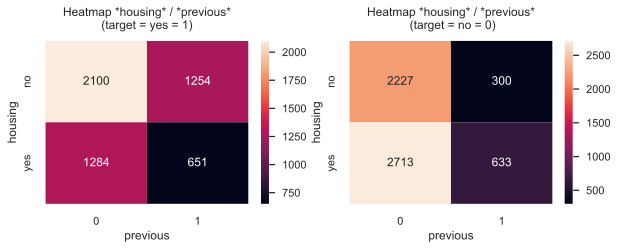

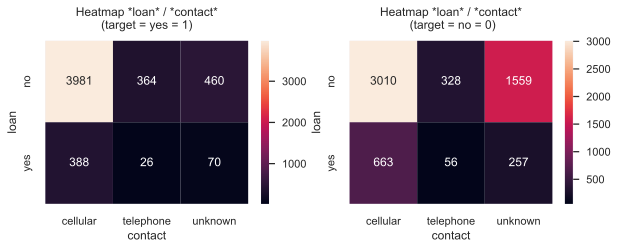

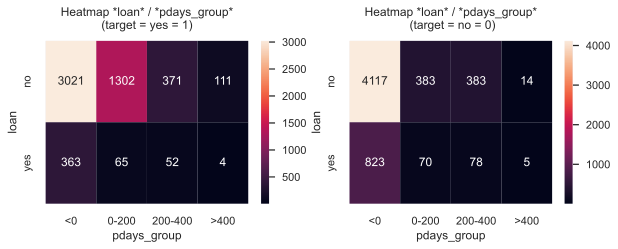

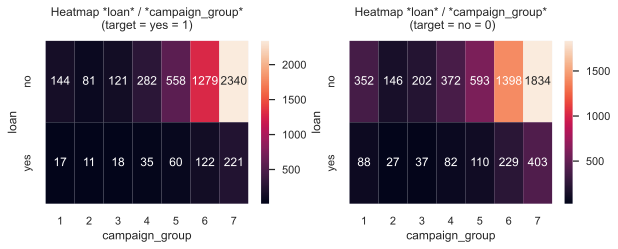

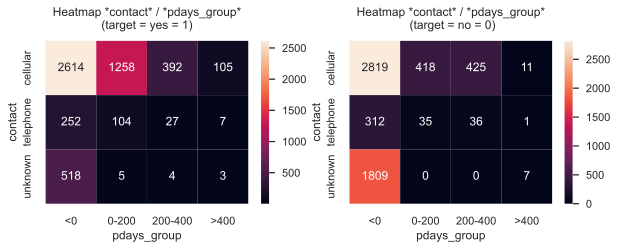

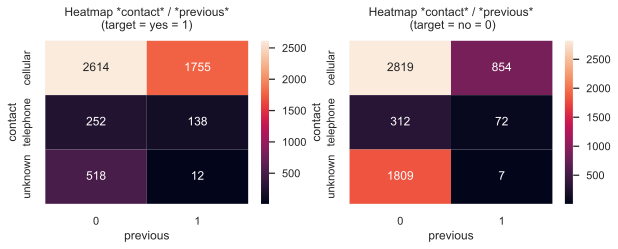

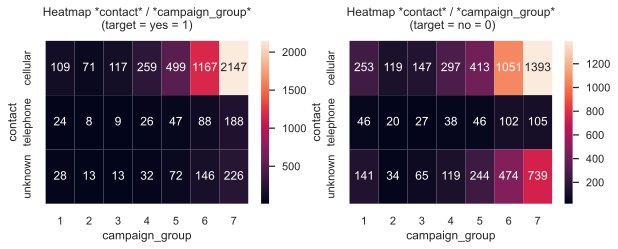

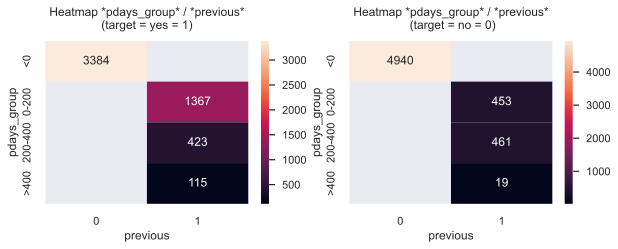

In [72]:
# визуализируем взаимосвязь категориальных признаков
for pair in features_pair[60:91]: # оставшиеся пары
    heatmap_pair_features(
        df, # датасет
        pair[0], # первый признак
        pair[1], # второй признак
        2000, # минимальный уровень кол-ва значений в классе 1 для вывода 
        0.1, 0.3, # диапазон долей несбалансированности классов для вывода
        h_size=10 # ширина графика
    )

In [73]:
# создадим признак housing(no)_previous(1)
df['housing(no)_previous(1)'] = df.apply(
    lambda row: 1 if ((row['housing'] == 'no') & (row['previous'] == 1)) else 0,
    axis=1
)
# создадим признак loan(no)_contact(cellular)
df['loan(no)_contact(cellular)'] = df.apply(
    lambda row: 1 if ((row['loan'] == 'no') & (row['contact'] == 'cellular')) else 0,
    axis=1
)
# создадим признак loan(no)_pdays_group(0-200)
df['loan(no)_pdays_group(0-200)'] = df.apply(
    lambda row: 1 if ((row['loan'] == 'no') & (row['pdays_group'] == '0-200')) else 0,
    axis=1
)
# создадим признак loan(no)_campaign_group(7)
df['loan(no)_campaign_group(7)'] = df.apply(
    lambda row: 1 if ((row['loan'] == 'no') & (row['campaign_group'] == 7)) else 0,
    axis=1
)
# создадим признак conatct(cellular)_pdays_group(0-200)
df['conatct(cellular)_pdays_group(0-200)'] = df.apply(
    lambda row: 1 if ((row['contact'] == 'cellular') & (row['pdays_group'] == '0-200')) else 0,
    axis=1
)
# создадим признак conatct(cellular)_previous(1)
df['conatct(cellular)_previous(1)'] = df.apply(
    lambda row: 1 if ((row['contact'] == 'cellular') & (row['previous'] == 1)) else 0,
    axis=1
)
# создадим признак conatct(cellular)_campaign_group(7)
df['conatct(cellular)_campaign_group(7)'] = df.apply(
    lambda row: 1 if ((row['contact'] == 'cellular') & (row['campaign_group'] == 7)) else 0,
    axis=1
)
# создадим признак pdays_group(0-200)_previous(1)
df['pdays_group(0-200)_previous(1)'] = df.apply(
    lambda row: 1 if ((row['pdays_group'] == '0-200') & (row['previous'] == 1)) else 0,
    axis=1
)


## 4. Сохраним полученный датасет

In [74]:
df.to_csv('data/df_EDA.csv', index=False)

## 5. Подготовка данных

### 5.1. Удалим пропуски в данных

In [75]:
# список признаков с неявными пропусками
nan_category_features = ['job', 'education', 'contact', 'poutcome']

# превращаем неявные пропуски в явные
for feature in nan_category_features:
    df[feature] = df[feature].apply(
        lambda x: np.nan if x == 'unknown' else x
    )

In [76]:
# удалим признак poutcome
df_dropna = df.drop('poutcome', axis=1)

# удалим строки с пропусками
df_dropna = df_dropna.dropna()

print(f'Размер данных до удаления пропусков {df.shape}')
print(f'Размер данных после удаления пропусков {df_dropna.shape}')
reduction_percentage = 100 - df_dropna.shape[0] / df.shape[0] * 100
print(f'Датасет уменьшился на {round(reduction_percentage)} %')

Размер данных до удаления пропусков (11162, 49)
Размер данных после удаления пропусков (8376, 48)
Датасет уменьшился на 25 %


### 5.2. Выделяем целевую переменную и предикторы, разделяем выборку на обучающую и тестовую.

In [77]:
# X - матрица наблюдений, y - столбец правильных ответов
X = df_dropna.drop('deposit', axis=1)
y = df_dropna['deposit']

In [78]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, # размер тестовой выборки
    random_state=random_state, # число отвечающее за генерацию случайных чисел
    stratify=y # стратификация, т.к. таргент несбалансирован
)

# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (6700, 47)
Test shape: (1676, 47)


### 5.3. Кодируем признаки

In [79]:
# выделяем признаки для OneHotEncoding
columns_to_change = X.drop([
    # числовые непрерывные признаки
    'age','balance', 'duration', 'campaign', 'pdays', 
    'AgeBalanceRatio', 'DurationCampaignRatio','PdaysCampaignRatio',
    # порядковые категориальные признаки
    'duration_group', 'campaign_group'
    ], axis=1).columns.to_list()

In [80]:
# кодируем тренировочную и тестовую выборки по отдельности, обучаясь на тренировочной
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

### 5.4. Поиск выбросов

In [81]:
# создаем признак для пометки выбросов
X_train_new['ouliers'] = 0
X_test_new['ouliers'] = 0

# используем класс EllipticEnvelope  
ee = EllipticEnvelope(contamination=0.01)
# обучаем и находим выбросы на тренировочной выборке
y_predicted_train = ee.fit_predict(X_train_new) 
# находим выбросы на тестовой выборке
y_predicted_test = ee.predict(X_test_new) 

# помечаем выбросы на тренировочной выборке
mask = y_predicted_train == -1
X_train_new.loc[mask, 'ouliers'] = 1

# помечаем выбросы на тестовой выборке
mask = y_predicted_test == -1
X_test_new.loc[mask, 'ouliers'] = 1

### 5.5. Нормализуем данные

In [82]:
# нормализуем данные

scaler = preprocessing.RobustScaler()             # RobustScaler показал себя чуть лучше
scaler.fit(X_train_new)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train_new)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test_new)      # fransform() на test данных

## 6. Решение задачи классификации: логистическая регрессия и решающие деревья

### 6.1. Логистическая регрессия

In [83]:
# Создаём модель логистической регрессии
model_lr = linear_model.LogisticRegression(
    random_state = random_state
    )
 
# обучаем модель
model_lr.fit(X_train_scaled, y_train)

# делаем предсказание на тренировочной и тестовой выборке
y_train_pred = model_lr.predict(X_train_scaled)
y_test_pred = model_lr.predict(X_test_scaled)

# расчитываем и выводим метрику на тренировочной выборке
print('Train scores')
print(metrics.classification_report(y_train, y_train_pred))
print('-' * 60)
print('Test scores')
# расчитываем и выводим метрику на тестовой выборке
print(metrics.classification_report(y_test, y_test_pred))

Train scores
              precision    recall  f1-score   support

          no       0.82      0.80      0.81      3093
         yes       0.83      0.85      0.84      3607

    accuracy                           0.82      6700
   macro avg       0.82      0.82      0.82      6700
weighted avg       0.82      0.82      0.82      6700

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

          no       0.81      0.80      0.80       774
         yes       0.83      0.84      0.83       902

    accuracy                           0.82      1676
   macro avg       0.82      0.82      0.82      1676
weighted avg       0.82      0.82      0.82      1676



### 6.2. Дерево решений

In [84]:
# Создаём объект класса DecisionTreeClassifier
model_dt = tree.DecisionTreeClassifier(
    random_state = random_state 
)

# Обучаем дерево решений 
model_dt.fit(X_train_scaled, y_train)

# Делаем предсказание класса для тренировочных и тестовых данных
y_train_pred = model_dt.predict(X_train_scaled)
y_test_pred = model_dt.predict(X_test_scaled)

#Выводим отчёт о метриках классификации
print('Train scores')
print(metrics.classification_report(y_train, y_train_pred))
print('-' * 60)
print('Test scores')
print(metrics.classification_report(y_test, y_test_pred))

Train scores
              precision    recall  f1-score   support

          no       1.00      1.00      1.00      3093
         yes       1.00      1.00      1.00      3607

    accuracy                           1.00      6700
   macro avg       1.00      1.00      1.00      6700
weighted avg       1.00      1.00      1.00      6700

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

          no       0.72      0.75      0.73       774
         yes       0.78      0.76      0.77       902

    accuracy                           0.75      1676
   macro avg       0.75      0.75      0.75      1676
weighted avg       0.75      0.75      0.75      1676



На примере дерева решений определим важность признаков

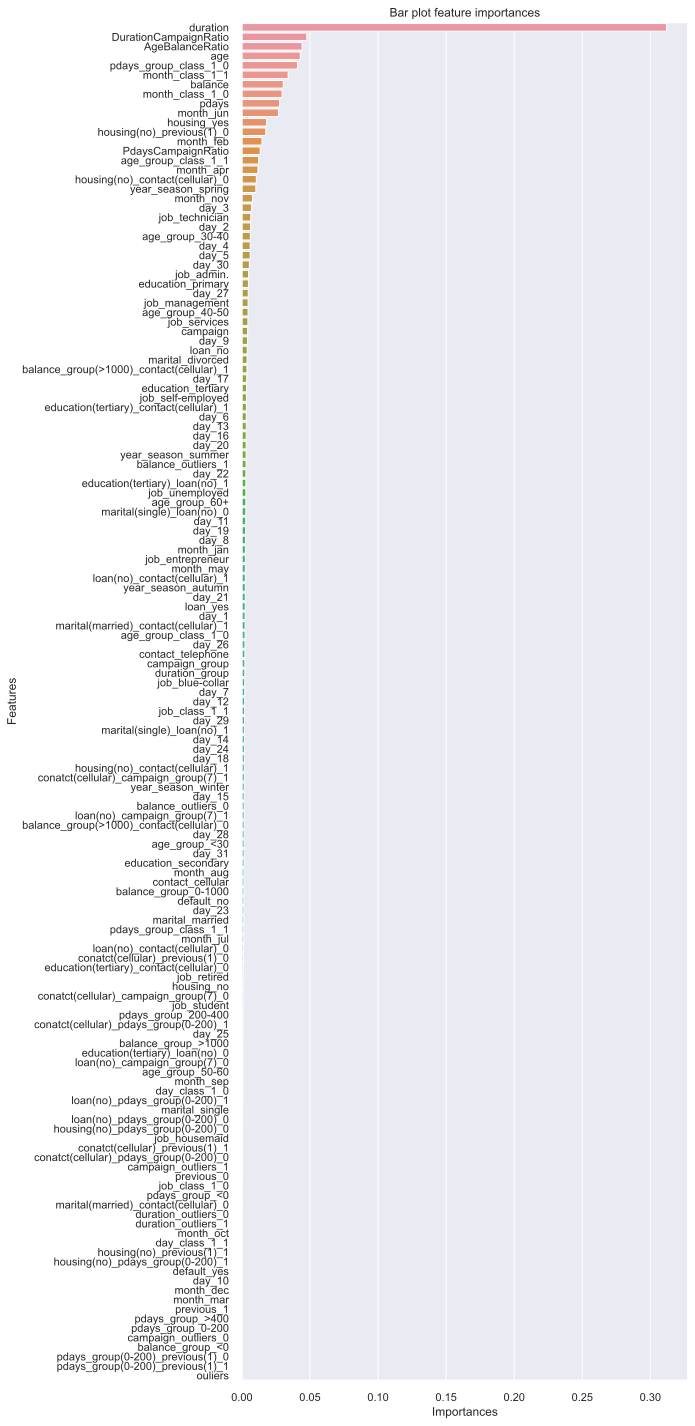

In [85]:
fig, ax = plt.subplots(figsize=(8, 25)) # фигура + координатная плоскость
feature = X_train_new.columns #признаки
feature_importances = model_dt.feature_importances_ # важность признаков
# создаем объект Series, чтобы отсортировать по важности признаки
feature_importances_series = pd.Series(
    data=feature_importances,
    index=feature
).sort_values(ascending=False)
# Строим столбчатую диаграмму
sns.barplot(x=feature_importances_series, y=feature_importances_series.index, ax=ax);
# Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Importances')
ax.set_ylabel('Features');

**Выводы:**
- модель логистической регрессии показала себя лучше на данной итерации, чем на предыдущей
- модель дерева решений имеет явные признаки переобучения и показала себя опять хуже, чем модель логистической регрессии
- наиболее важный признак - **duration**, однако на верхние места также выбились наши новые признаки, что вызыввает чувство удовлетворения
- выбросы, найденные методом Тьюки, для модели более важны, чем выбросы, найденные методами библиотеки sklearn

## 7. Решение задачи классификации: ансамбли моделей

### 7.1. Случайный лес

In [86]:
# Создаем объект класса случайный лес
model_rf = ensemble.RandomForestClassifier(
    random_state = random_state 
)

# Обучаем модель 
model_rf.fit(X_train_scaled, y_train)

# Делаем предсказание класса
y_pred_train = model_rf.predict(X_train_scaled)
y_pred_test = model_rf.predict(X_test_scaled)

# Выводим отчет о метриках
print('Train scores')
print(metrics.classification_report(y_train, y_pred_train))
print('-' * 60)
print('Test scores')
print(metrics.classification_report(y_test, y_pred_test))

Train scores
              precision    recall  f1-score   support

          no       1.00      1.00      1.00      3093
         yes       1.00      1.00      1.00      3607

    accuracy                           1.00      6700
   macro avg       1.00      1.00      1.00      6700
weighted avg       1.00      1.00      1.00      6700

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

          no       0.85      0.77      0.81       774
         yes       0.81      0.88      0.85       902

    accuracy                           0.83      1676
   macro avg       0.83      0.82      0.83      1676
weighted avg       0.83      0.83      0.83      1676



Неплохая метрика *F1-score* = 0.85, однако модель снова переобучена.  
Определим важность признаков для данной модели.

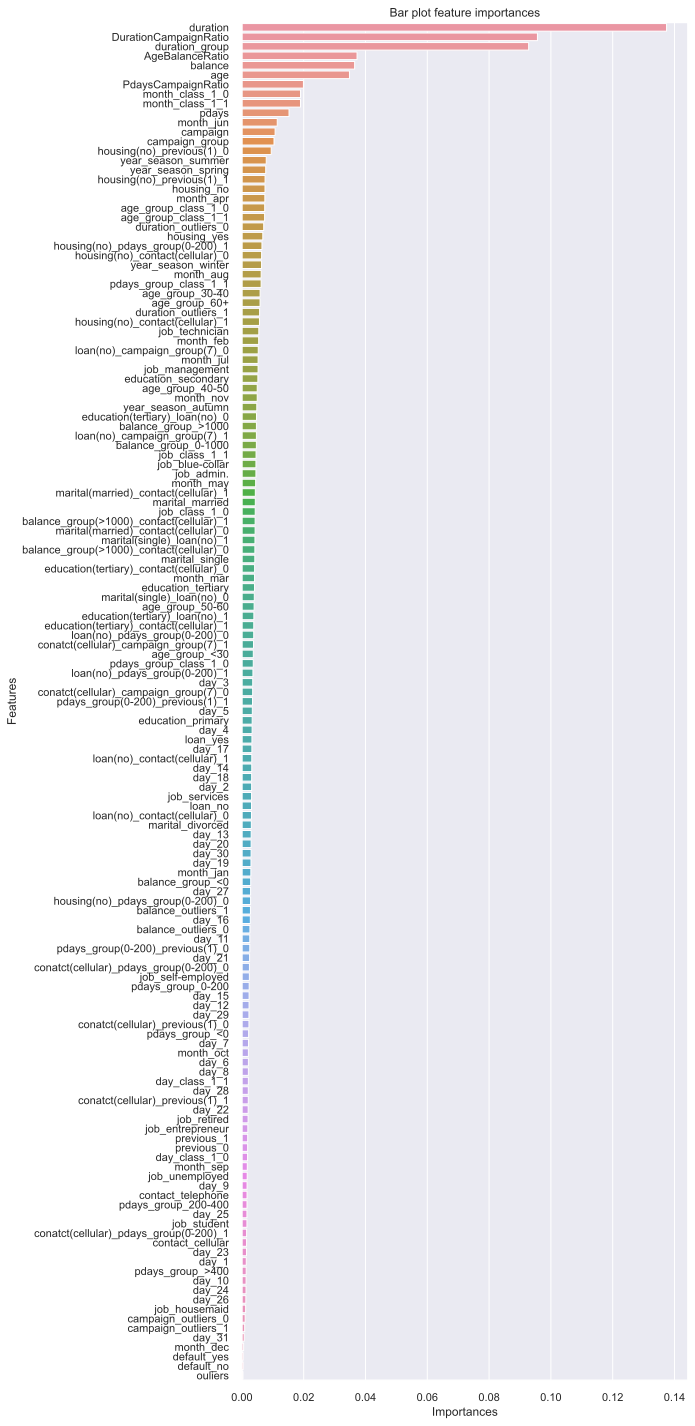

In [87]:
fig, ax = plt.subplots(figsize=(8, 25)) # фигура + координатная плоскость
feature = X_train_new.columns #признаки
feature_importances = model_rf.feature_importances_ # важность признаков
# создаем объект Series, чтобы отсортировать по важности признаки
feature_importances_series = pd.Series(
    data=feature_importances,
    index=feature
).sort_values(ascending=False)
# Строим столбчатую диаграмму
sns.barplot(x=feature_importances_series, y=feature_importances_series.index, ax=ax);
# Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Importances')
ax.set_ylabel('Features');

По сравнению с признаками дерева решения важность признака **duration** стала меньше и подросла важность остальных признаков, что делает график более равномерным. В остальном выводы те же, что и выше.

### 7.2. Градиентный бустинг

In [88]:
# Создаем объект класса градиентный бустинг
model_gb = ensemble.GradientBoostingClassifier(
    random_state = random_state
)

model_gb.fit(X_train_scaled, y_train)

# Делаем предсказание класса
y_pred_train = model_gb.predict(X_train_scaled)
y_pred_test = model_gb.predict(X_test_scaled)

# Выводим отчет о метриках
print('Train scores')
print(metrics.classification_report(y_train, y_pred_train))
print('-' * 60)
print('Test scores')
print(metrics.classification_report(y_test, y_pred_test))

Train scores
              precision    recall  f1-score   support

          no       0.86      0.81      0.84      3093
         yes       0.85      0.89      0.87      3607

    accuracy                           0.85      6700
   macro avg       0.85      0.85      0.85      6700
weighted avg       0.85      0.85      0.85      6700

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

          no       0.84      0.79      0.81       774
         yes       0.83      0.87      0.85       902

    accuracy                           0.83      1676
   macro avg       0.83      0.83      0.83      1676
weighted avg       0.83      0.83      0.83      1676



### 7.3. Стекинг

In [89]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', linear_model.LogisticRegression(
        random_state = random_state
    )),
    ('dt',  tree.DecisionTreeClassifier(
        random_state = random_state
    )),
    ('gb', ensemble.GradientBoostingClassifier(
        random_state = random_state
    ))
]

# Создаем объект класса стекинг
stacking_cl = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        random_state = random_state
    )
)

# Обучаем модель
stacking_cl.fit(X_train_scaled, y_train)

# Делаем предсказание класса
y_pred_train = stacking_cl.predict(X_train_scaled)
y_pred_test = stacking_cl.predict(X_test_scaled)

# Выводим отчет о метриках
print('Train scores')
print(metrics.classification_report(y_train, y_pred_train))
print('-' * 60)
print('Test scores')
print(metrics.classification_report(y_test, y_pred_test))

Train scores
              precision    recall  f1-score   support

          no       0.88      0.84      0.86      3093
         yes       0.86      0.90      0.88      3607

    accuracy                           0.87      6700
   macro avg       0.87      0.87      0.87      6700
weighted avg       0.87      0.87      0.87      6700

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

          no       0.84      0.79      0.81       774
         yes       0.83      0.87      0.85       902

    accuracy                           0.83      1676
   macro avg       0.83      0.83      0.83      1676
weighted avg       0.83      0.83      0.83      1676



Ансамбли показали себя лучше - 0.85 по целевой метрике. Модель случайного леса переобучена. Однако серьезного улучшения метрики по сравнению с предыдущей итерацией нет.

## 8. Итоги и выводы

Метрики на **предыдущей** итерации (пропуски удалены)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-zvyz{background-color:#B0B3B2;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-pkkx{color:#E6000E;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Train</th>
    <th class="tg-ihq5" colspan="4">Test</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-8mdw">Метрики</td>
    <td class="tg-9kw6">Precision</td>
    <td class="tg-9kw6">Recall</td>
    <td class="tg-9kw6">F1-score</td>
    <td class="tg-9kw6">Accuracy</td>
    <td class="tg-9kw6">Precision</td>
    <td class="tg-9kw6">Recall</td>
    <td class="tg-ihq5">F1-score</td>
    <td class="tg-9kw6">Accuracy</td>
  </tr>
  <tr>
    <td class="tg-8mdw">Модели</td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
  </tr>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Логистическая регрессия</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.80</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Дерево решений</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.77</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.75</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.76</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.75</span></td>
  </tr>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Случайный лес</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.89</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Градиентный бустинг</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.89</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Стекинг</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.90</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
  </tr>
</tbody>
</table>

Метрики на **текущей** итерации (пропуски удалены)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-zvyz{background-color:#B0B3B2;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-pkkx{color:#E6000E;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Train</th>
    <th class="tg-ihq5" colspan="4">Test</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-8mdw">Метрики</td>
    <td class="tg-9kw6">Precision</td>
    <td class="tg-9kw6">Recall</td>
    <td class="tg-9kw6">F1-score</td>
    <td class="tg-9kw6">Accuracy</td>
    <td class="tg-9kw6">Precision</td>
    <td class="tg-9kw6">Recall</td>
    <td class="tg-ihq5">F1-score</td>
    <td class="tg-9kw6">Accuracy</td>
  </tr>
  <tr>
    <td class="tg-8mdw">Модели</td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
    <td class="tg-zvyz"></td>
  </tr>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Логистическая регрессия</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Дерево решений</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.78</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.76</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.77</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.75</span></td>
  </tr>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Случайный лес</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">1.00</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.88</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Градиентный бустинг</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.89</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Стекинг</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.90</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-pkkx"><span style="font-weight:normal;font-style:normal;color:#E6000E">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
  </tr>
</tbody>
</table>

- был произведен полноценный анализ начальных данных
- отмечена корреляция (от средней до очень сильной) признаков **pdays** и **previous**
- отмечена высокая степень корреляции с таргетом у следующих начальных числовых признаков (по нисходящей): **duration**, **previous**, **pdays**.
- был проведен разведывательный анализ данных
- пропуски были удалены
- созданы дополнительные категориальные и числовые признаки
---
- одиночные модели на данной итерации улучшили свои метрики
- ансамбли практически не изменили свои метрики
- модели дерева решений и случайного леса переобучены
- новые созданные признаки попали в топ важных признаков для моделей деревьев
- выбросы, найденные методом Тьюки, для тех же моделей имеют большую ценность, чем выбросы, найденные методами библиотеки sklearn. Возможная причина - метод Тьюки применялся на всем датасете, а методы sklearn обучались на тренировочной выборке. Другими словами мы "слили" тестовые данные в модель, когда применяли метод Тьюки.
- был произведен анализ пропусков в категориальных признаках. В признаках **job** и **education** пропусков немного и классы в них сбалансированы. В признаках **contact** и **poutcome** их значительно больше (2-е и 1-е место по частоте) и классы несбалансированы в сторону отказа от депозита в рамках текущей компании. Возможно (это только мое предположение) именно это повлияло на то, что при замене пропусков константами на предыдущей итерации росли метрики класса 0 таргета.
---
- не проводился отбор признаков
- модели обучались с настройками по умолчанию, не проводились настройки гиперпараметров
- ансамбли показали себя лучше, но сохраняется дисбаланс метрик *precision* и *recall* (мне кажется это важным)
- недостаточно качественно были обработаны непрерывные числовые признаки


Еще предстоит много работы и экспериментов. Идем на следующую итерацию!